# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import spacy
from nltk.corpus import stopwords

# Importing Dataset

In [3]:
df= pd.read_csv("data.csv")

# EDA

In [4]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [6]:
df.describe()

,Text,Emotion
count,21459,21459
unique,21405,6
top,i feel so tortured by it,happy
freq,2,7029


In [7]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [8]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

# Data Visualization

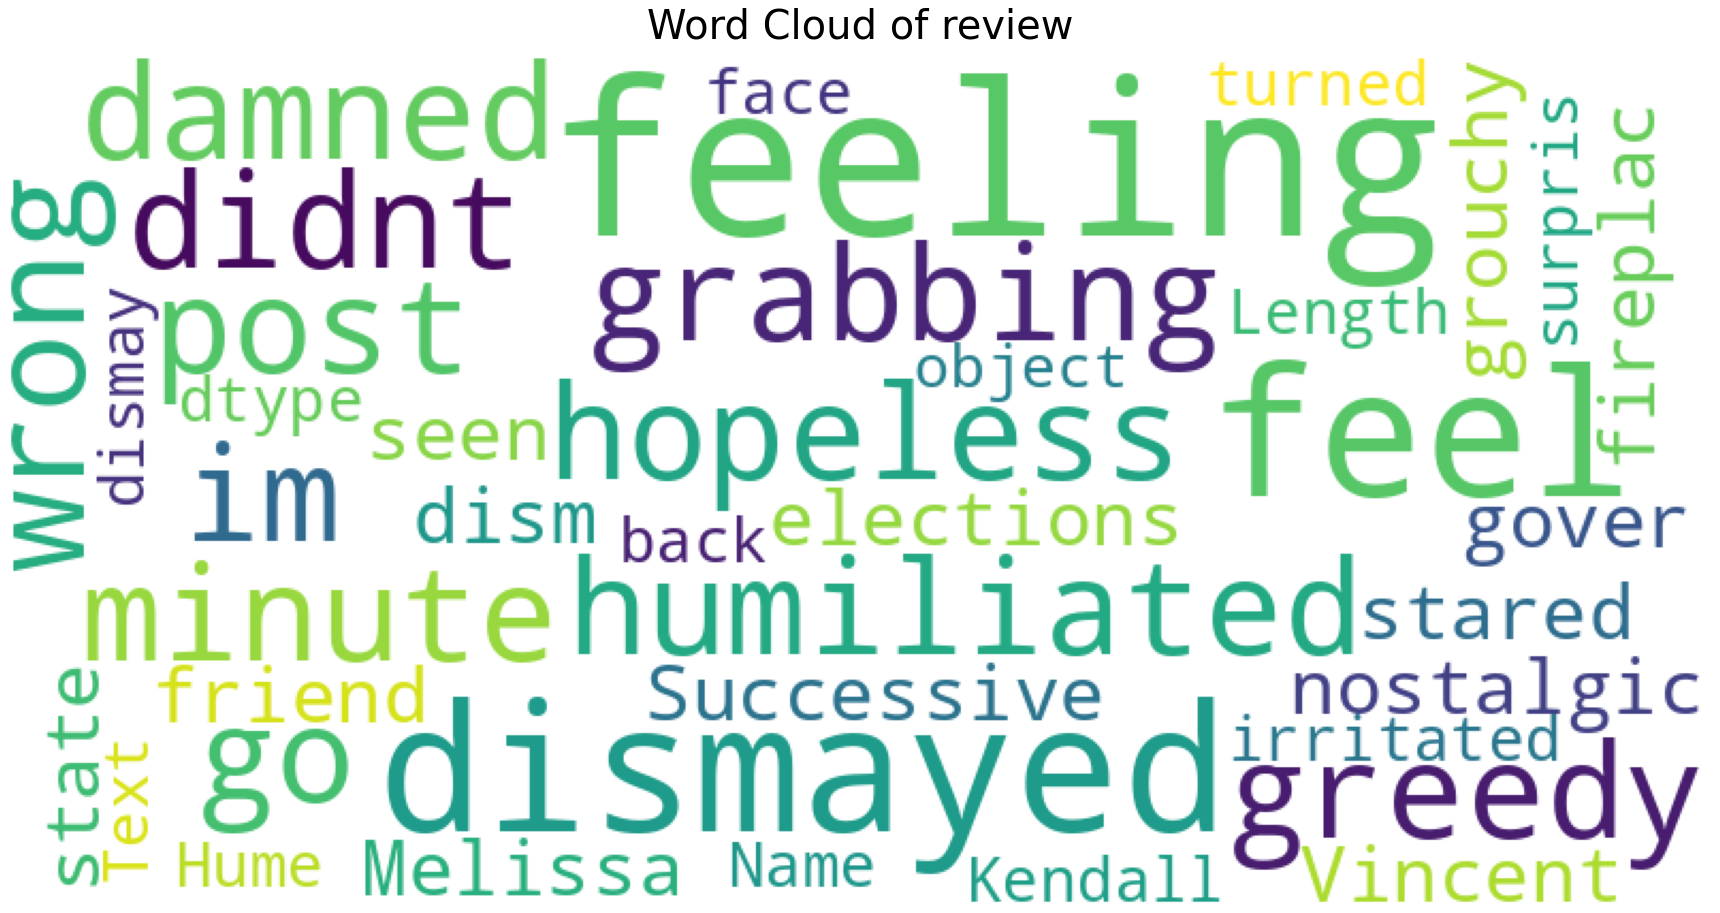

In [9]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df["Text"], title="Word Cloud of review")

<AxesSubplot:xlabel='Emotion', ylabel='count'>

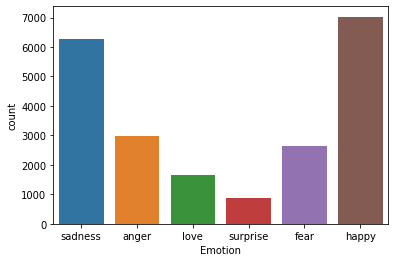

In [10]:
sns.countplot(x = 'Emotion',data = df)

# Text Cleaning

In [11]:
nlp = spacy.load("en_core_web_sm")

# Define functions to calculate various linguistic features
def sentence_length_by_character(text):
    return len(text)

def sentence_length_by_word(text):
    words = nltk.word_tokenize(text)
    return len(words)

def word_length(text):
    words = nltk.word_tokenize(text)
    word_lengths = [len(word) for word in words]
    return sum(word_lengths) / len(words)

def sentence_vocabulary(text):
    words = nltk.word_tokenize(text)
    return len(set(words))

def stopword_density(text):
    words = nltk.word_tokenize(text)
    stopwords_count = len([word for word in words if word.lower() in stopwords.words("english")])
    return stopwords_count / len(words)

def density_of_noun(text):
    doc = nlp(text)
    noun_count = len([token for token in doc if token.pos_ == "NOUN"])
    return noun_count / len(doc)

def density_of_adjective(text):
    doc = nlp(text)
    adj_count = len([token for token in doc if token.pos_ == "ADJ"])
    return adj_count / len(doc)

def adjective_to_noun_ratio(text):
    doc = nlp(text)
    adj_count = len([token for token in doc if token.pos_ == "ADJ"])
    noun_count = len([token for token in doc if token.pos_ == "NOUN"])
    if noun_count == 0:
        return 0  # To avoid division by zero
    return adj_count / noun_count

# Apply the functions to your DataFrame
df["Sentence Length (Character)"] = df["Text"].apply(sentence_length_by_character)
df["Sentence Length (Word)"] = df["Text"].apply(sentence_length_by_word)
df["Word Length"] = df["Text"].apply(word_length)
df["Sentence Vocabulary"] = df["Text"].apply(sentence_vocabulary)
df["Stopword Density"] = df["Text"].apply(stopword_density)
df["Density of Noun"] = df["Text"].apply(density_of_noun)
df["Density of Adjective"] = df["Text"].apply(density_of_adjective)
df["Adjective to Noun Ratio"] = df["Text"].apply(adjective_to_noun_ratio)

# Display the updated DataFrame
print(df)

                                                    Text  Emotion  \
0                                i didnt feel humiliated  sadness   
1      i can go from feeling so hopeless to so damned...  sadness   
2       im grabbing a minute to post i feel greedy wrong    anger   
3      i am ever feeling nostalgic about the fireplac...     love   
4                                   i am feeling grouchy    anger   
...                                                  ...      ...   
21454               Melissa stared at her friend in dism     fear   
21455  Successive state elections have seen the gover...     fear   
21456               Vincent was irritated but not dismay     fear   
21457  Kendall-Hume turned back to face the dismayed ...     fear   
21458                    I am dismayed , but not surpris     fear   

       Sentence Length (Character)  Sentence Length (Word)  Word Length  \
0                               23                       4     5.000000   
1                    

In [12]:
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

# Apply the sentiment analysis function to the 'Text' column
df['Sentiment_Scores'] = df['Text'].apply(get_sentiment_scores)

# Extract compound scores for sentiment labels
df['Sentiment_Label'] = df['Sentiment_Scores'].apply(lambda x: 'Positive' if x['compound'] > 0 else ('Negative' if x['compound'] < 0 else 'Neutral')) 

In [14]:
Sentiment_mapping = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

df['Sentiment_Index'] = df['Sentiment_Label'].map(Sentiment_mapping)

In [16]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
df['Text'] = df['Text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [17]:
emotion_mapping = {
    'happy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5
}

df['Emotion_Index'] = df['Emotion'].map(emotion_mapping)

In [18]:
X = df['Text']
y = df['Emotion_Index']

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
X = tfidf_vectorizer.fit_transform(X).toarray()

In [20]:
pickle.dump(tfidf_vectorizer,open('tf.pkl', 'wb'))

In [21]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Algorithms

# SMOTE + SYSAn(GS) + RF+SVM+XGB

In [22]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y , test_size =0.2,random_state=0)

In [26]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
estimator = []
estimator.append(('XGB', XGBClassifier()))
estimator.append(('RF', RandomForestClassifier()))
estimator.append(('SVM', SVC(probability=True)))
vot_hard = VotingClassifier(estimators = estimator, voting ='soft')

In [ ]:
from genetic_selection import GeneticSelectionCV
model = GeneticSelectionCV(
    vot_hard, cv=2, verbose=0,
    scoring="accuracy", max_features=1, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
evaluate(model,X_train, X_test, y_train, y_test)